# Selecting a model architecture
We are going to use an anomaly detection approach. We will try to learn unique characteristics of toxic class. We don't have a extensive dataset of non-toxic plants, so I think this kind of approach will work best.

We'll look into:
* One-Class Convolutional Neural Networks (OC-CNN) (https://arxiv.org/pdf/1901.08688)
* Convolutional Autoencoders (CAEs)

Fine-tuning a plantnet-300k model might be a good idea.


In [19]:
import torch
import torchvision
import os
import sys
from pathlib import Path

In [20]:
# check torch version
print(torch.__version__)

2.4.0+cu124


In [21]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [22]:
toxic_dir = Path("../data/toxic")
non_toxic_dir = Path("../data/non-toxic")

In [23]:
from utils import load_model
from torchvision.models import resnet34

plantnet_model_path = Path("../models/plantnet_resnet34_best.tar")
plantnet_model = resnet34(num_classes=1081)

load_model(plantnet_model, filename=plantnet_model_path, use_gpu=True)

/home/kaka/repo/plants-toxic-for-cats/notebooks/utils.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(filename, map_location=device)


22

In [24]:
# get the transforms
type(plantnet_model_path)

pathlib.PosixPath

In [25]:
from torchvision.models import ResNet34_Weights
weights = ResNet34_Weights.DEFAULT
transform = weights.transforms()

In [26]:
transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [27]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# load the datasets
sub_20_dir = Path("../data/sub_20")
train_dir = sub_20_dir / 'train'
test_dir = sub_20_dir / 'test'
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

In [28]:
print(train_dataset.class_to_idx)
print(test_dataset.class_to_idx)

labels_mapping = {0: "0 | toxic", 1: "1 | non-toxic"}

{'0_toxic': 0}
{'0_toxic': 0, '1_non-toxic': 1}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


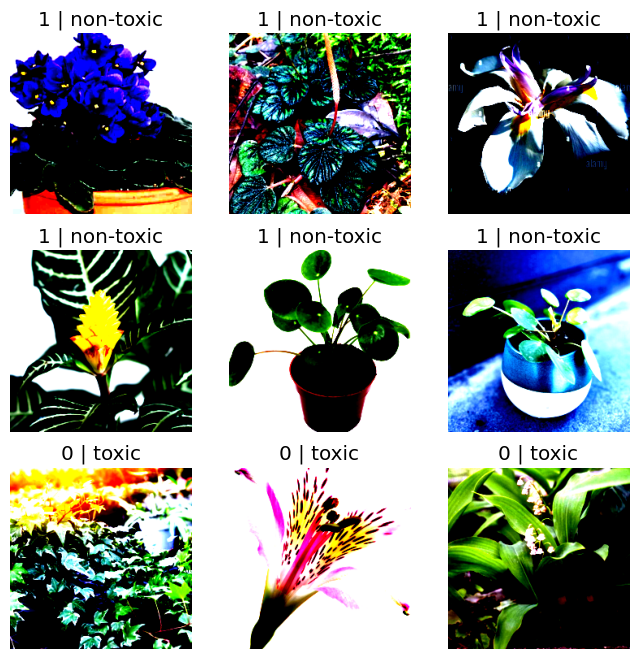

In [29]:
# visualize 9 samples from test dataset
import matplotlib.pyplot as plt

plt.style.use('ggplot')
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_dataset), size=(1,)).item()
    img, label = test_dataset[sample_idx]
    img = img.numpy().transpose((1, 2, 0))
    figure.add_subplot(rows, cols, i)
    plt.title(labels_mapping[label])
    plt.axis("off")
    plt.imshow(img)

In [30]:
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [31]:
from torchinfo import summary
summary(model=plantnet_model,
        input_size=(batch_size, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Trainable
ResNet (ResNet)                          [32, 3, 224, 224]         [32, 1081]                --                        True
├─Conv2d (conv1)                         [32, 3, 224, 224]         [32, 64, 112, 112]        9,408                     True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]        [32, 64, 112, 112]        128                       True
├─ReLU (relu)                            [32, 64, 112, 112]        [32, 64, 112, 112]        --                        --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]        [32, 64, 56, 56]          --                        --
├─Sequential (layer1)                    [32, 64, 56, 56]          [32, 64, 56, 56]          --                        True
│    └─BasicBlock (0)                    [32, 64, 56, 56]          [32, 64, 56, 56]          --                        True
│    │ 

In [32]:
import torch.nn as nn

class OCCNN_0(nn.Module):
    def __init__(self, backbone, num_classes=2):
        super(OCCNN_0, self).__init__()
        
        for param in backbone.parameters():
            param.requires_grad = False
        
        backbone_num_features = backbone.fc.in_features
        backbone.fc = nn.Linear(backbone_num_features, 20)
        
        self.backbone = backbone
        self.num_classes = num_classes
        
        self.classifier = nn.Sequential(
            nn.Linear(backbone_num_features, backbone_num_features),
            nn.InstanceNorm1d(backbone_num_features),
            nn.ReLU(),
            nn.Linear(backbone_num_features, 2)
        )
        
    def forward(self, x : torch.Tensor):
        x = self.backbone(x)
        batch_size = x.size(0)
        pseudo_negative = torch.randn(batch_size, x.size(1), device=x.device) * 0.01
        inputs = torch.cat([x, pseudo_negative], dim=0)
        outputs = self.classifier(inputs)
        return outputs
        
        

In [33]:
occnn_0 = OCCNN_0(plantnet_model, num_classes=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])

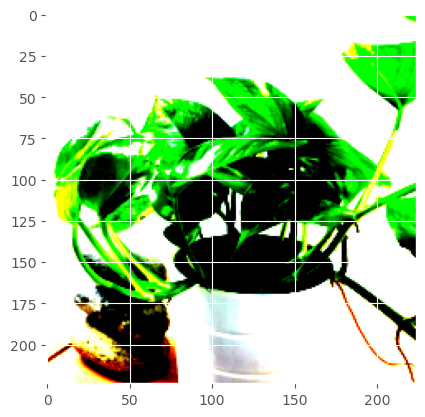

In [34]:
# select random image from test dataset
sample_idx = torch.randint(len(test_dataset), size=(1,)).item()
img, label = test_dataset[sample_idx]
plt.imshow(img.numpy().transpose((1, 2, 0)))
img.shape

In [35]:
plantnet_model = plantnet_model.to(device)
with torch.no_grad():
    outputs = plantnet_model(img.unsqueeze(0).to(device))
    print(outputs)

tensor([[ 0.3090,  0.2962, -0.0047, -0.3191,  0.1492, -0.2117, -0.3582, -0.1676,
         -0.5222, -0.1761, -0.0798,  0.1214, -0.0385, -0.1146, -0.3918, -0.0079,
          0.2143,  0.1279, -0.3319,  0.0956]], device='cuda:0')


In [36]:
img = img.unsqueeze(0).to(device)
occnn_0 = occnn_0.to(device)
with torch.no_grad():
    outputs = occnn_0(img)
    print(outputs)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x20 and 512x512)

In [41]:
#check if the model is trainable
for name, param in occnn_0.named_parameters():
    print(name, param.requires_grad)

backbone.conv1.weight False
backbone.bn1.weight False
backbone.bn1.bias False
backbone.layer1.0.conv1.weight False
backbone.layer1.0.bn1.weight False
backbone.layer1.0.bn1.bias False
backbone.layer1.0.conv2.weight False
backbone.layer1.0.bn2.weight False
backbone.layer1.0.bn2.bias False
backbone.layer1.1.conv1.weight False
backbone.layer1.1.bn1.weight False
backbone.layer1.1.bn1.bias False
backbone.layer1.1.conv2.weight False
backbone.layer1.1.bn2.weight False
backbone.layer1.1.bn2.bias False
backbone.layer1.2.conv1.weight False
backbone.layer1.2.bn1.weight False
backbone.layer1.2.bn1.bias False
backbone.layer1.2.conv2.weight False
backbone.layer1.2.bn2.weight False
backbone.layer1.2.bn2.bias False
backbone.layer2.0.conv1.weight False
backbone.layer2.0.bn1.weight False
backbone.layer2.0.bn1.bias False
backbone.layer2.0.conv2.weight False
backbone.layer2.0.bn2.weight False
backbone.layer2.0.bn2.bias False
backbone.layer2.0.downsample.0.weight False
backbone.layer2.0.downsample.1.weight 

After some thoughts I will try a different approach. I'll use the plantnet model to predict a plant and then hard code which plants are toxic.

In [64]:
import torch
from torchvision.transforms import v2

plantnet_model_path = Path("../models/plantnet_resnet34_best.tar")
plantnet_model = resnet34(num_classes=1081)

load_model(plantnet_model, filename=plantnet_model_path, use_gpu=True)

/home/kaka/repo/plants-toxic-for-cats/notebooks/utils.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(filename, map_location=device)


22

In [65]:
from torchvision.models import ResNet34_Weights

weights = ResNet34_Weights.DEFAULT
transforms = weights.transforms()
transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [66]:
transform = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [86]:
# do a prediction on a single image
from PIL import Image
img = Image.open(r"../data/bing_subset_20/test.jpg")

img_tensor = transform(img)
img_tensor = img_tensor.unsqueeze(0)

with torch.inference_mode():
    output = plantnet_model(img_tensor)
    print(output)
    
_, predicted_idx = torch.max(output, 1)

predicted_idx

tensor([[0.2384, 0.3390, 0.0416,  ..., 0.0011, 0.4287, 0.1608]])


tensor([204])

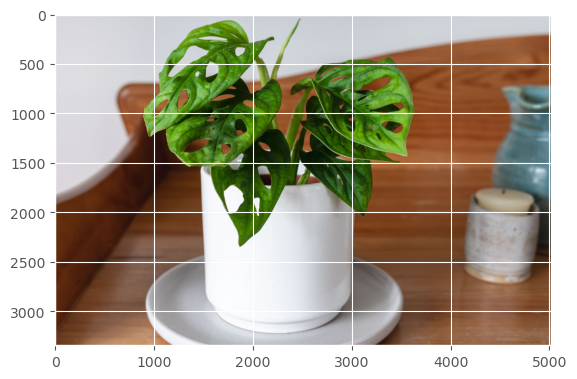

In [77]:
# display img
import matplotlib.pyplot as plt
import numpy as np

img = np.array(img)
plt.imshow(img)
